In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Dice, JaccardIndex
from tqdm import tqdm
from skimage import io
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, utils

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device = torch.device(device)

In [2]:
# Hyperparameters

LEARNING_RATE = 0.00005
WEIGHT_DECAY = 1e-5
UNFREEZE_WEIGHTS = True # If resnet weights need to be frozen or not
EPOCHS = 50
EPOCH_FREEZE = 20 # AFter how many epochs to unfreeze encoder
PROB_THRESHOLD = 0.5 # THreshold at which glacier is classified
MAKE_CSV = False
TEST_SIZE = 0.1
TRANSFORMS = 'normalize no'
LOSS = 'ce'
SMOOTH_FACTOR = 0.0001
BATCH_SIZE = 32
SHUFFLE_DATASET = True
DICE = Dice(average='micro', threshold = PROB_THRESHOLD).to(device)
JAC = JaccardIndex(task="multiclass", num_classes=2, threshold = PROB_THRESHOLD).to(device)

In [3]:
# Making dataset - images and masks folder should be in a folder named training_data

if MAKE_CSV:
    mypath = 'training_data/masks'
    mask_files = ['training_data/masks/'+f for f in listdir(mypath) if isfile(join(mypath, f))]

    valid_imgs = []
    count = 0

    for img_path in mask_files:
        img = io.imread(img_path)
        if img.var() > 0.001:
            valid_imgs.append(img_path[20:])

    mypath = 'training_data/images'
    img_files = ['images/'+ i for i in valid_imgs]
    mypath = 'training_data/masks'
    mask_files = ['masks/'+ i for i in valid_imgs]

    df = pd.DataFrame(list(zip(img_files, mask_files)), columns=[['img', 'mask']])
    df = df.sample(frac=1).reset_index(drop=True)
    
    train = df[:int((1-TEST_SIZE)*len(df))]
    test = df[int((1-TEST_SIZE)*len(df)):]
    train.to_csv('train_clean.csv', index = False)
    test.to_csv('test_clean.csv', index = False)

In [4]:
# Custom Dataloader

class GlacierDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = torch.tensor(io.imread(img_path).transpose(2,0,1)).float() # N, H, W format
        
        green = image[1]
        swir = image[4]
        ndsi = (green - swir + SMOOTH_FACTOR)/(green + swir+ SMOOTH_FACTOR)
        ndsi = ndsi.unsqueeze(dim=0)
        image = torch.cat((ndsi, image), dim=0)

        nir = image[3]
        ndwi = (green - nir + SMOOTH_FACTOR)/(green + nir+ SMOOTH_FACTOR)
        ndwi = ndwi.unsqueeze(dim=0)
        image = torch.cat((ndwi, image), dim=0)

        label_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        label = torch.tensor(io.imread(label_path).transpose(2,0,1))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



In [5]:
if TRANSFORMS == 'normalize':
    TRANSFORM = transforms.Compose([]) 
    # Can add other transforms like cropping and rotation - Image augmentation
else:
    TRANSFORM = None

train_dataset = GlacierDataset('train_clean.csv', 'training_data', transform=TRANSFORM)
test_dataset = GlacierDataset('test_clean.csv', 'training_data', transform=TRANSFORM)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

In [6]:
import torchvision.models as models
import torch.nn as nn
import torch
from torch.nn.functional import interpolate
# from torchvision.models import resnet50, ResNet50_Weights


class UNet(nn.Module):
    def __init__(self, n_class, freeze_encoder=True):
        self.n_class = n_class
        self.freeze_encoder = freeze_encoder
        super(UNet, self).__init__()
        
        resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

        if self.freeze_encoder:
            for param in resnet.parameters():
                param.requires_grad = False
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.resnet[0] = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3,bias=False)
        
        self.relu = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, dilation=1,
                                          output_padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        
        self.deconv3 = nn.ConvTranspose2d(1024, 256, kernel_size=3, stride=2, padding=1, dilation=1,
                                          output_padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(512, 64, kernel_size=3, stride=2, padding=1, dilation=1,
                                          output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.deconv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn6 = nn.BatchNorm2d(32)
        self.deconv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn7 = nn.BatchNorm2d(16)
        self.deconv8 = nn.ConvTranspose2d(16, 4, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn8 = nn.BatchNorm2d(4)
        self.c8 = nn.Conv2d(4, 4, 6, stride=8, padding=0)
        
        self.dropout = nn.Dropout(p=0.2)
        self.classifier = nn.Conv2d(4, self.n_class, kernel_size=1)
        # self.classifier = nn.Conv2d(4, 1, kernel_size=1)
        self.softmax = torch.nn.Softmax(dim=1)
        

    def forward(self, images):
        x0 = self.resnet[0](images)
        x1 = self.resnet[1](x0)
        x2 = self.resnet[2](x1)
        x3 = self.resnet[3](x2)
        x4 = self.resnet[4](x3)
        x5 = self.resnet[5](x4)
        x6 = self.resnet[6](x5)
        out = self.resnet[7](x6)

        y1 = self.bn1(self.relu(self.deconv1(out)))
        y1 = torch.cat([y1, x6], dim=1)
        
        y2 = self.bn2(self.relu(self.deconv2(y1)))
        y2 = torch.cat([y2, x5], dim=1)
        
        y3 = self.bn3(self.relu(self.deconv3(y2)))
        y3 = torch.cat([y3, x4], dim=1)

      
        y4 = self.bn4(self.relu(self.deconv4(y3)))
        y4 = torch.cat([y4, x2], dim=1)
 
        y5 = self.bn5(self.relu(self.deconv5(y4)))
        y6 = self.bn6(self.relu(self.deconv6(y5)))
        y7 = self.bn7(self.relu(self.deconv7(y6)))
        y8 = self.bn8(self.relu(self.deconv8(y7)))
        y9 = self.c8(y8)

        # score = self.softmax(self.classifier(y9))
        score = self.classifier(y9)
        # score = y8
        return score

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.

    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """
    shape = np.array(input.shape)
    shape[1] = num_classes
    shape = tuple(shape)
    result = torch.zeros(shape)
    result = result.scatter_(1, input.cpu(), 1)

    return result


class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

In [8]:
def train(torch_model, epochs=10, loss_fn='ce'):
    for epoch in range(epochs):
        if UNFREEZE_WEIGHTS and epoch>EPOCH_FREEZE:
                for param in torch_model.resnet.parameters():
                    param.requires_grad = True

        for i, (imgs, segs) in enumerate(tqdm(train_dataloader)):
            imgs = imgs.to(device)
            if loss_fn == 'ce':
                segs = segs.squeeze(1).to(device).long() # For cross entropy loss
            elif loss_fn == 'dice':
                segs = make_one_hot(segs.long(), 2).to(device) # For dice loss
            else:
                segs = segs.squeeze(1).to(device).long()

            outputs = torch_model.forward(imgs)
            
            if loss_fn == 'ce':
                loss = criterion(outputs, segs)
            elif loss_fn == 'dice':
                loss = criterion(outputs.to(device), segs.squeeze(1).long().to(device))
            else:
                loss = criterion(outputs, segs)
                
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())
        print(epoch, loss)
        

In [9]:
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
torch_model = UNet(n_class=2, freeze_encoder=False)

optimizer = torch.optim.Adam(torch_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

if LOSS == 'ce':
    criterion = nn.CrossEntropyLoss()
elif LOSS == 'dice':
    criterion = BinaryDiceLoss()
elif LOSS == 'mse':
    criterion = nn.MSELoss()
else:
    criterion = nn.CrossEntropyLoss()

train_losses = []

torch_model = torch_model.to(device=device) 



In [10]:
# torch_model = torch.load('full_dataset_model_ce_clean50_shuffle_separate')

In [11]:
from datetime import datetime 

start_time = datetime.now() 

train(torch_model, epochs=EPOCHS, loss_fn=LOSS)
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

  0%|          | 0/410 [00:00<?, ?it/s]

0 tensor(0.2170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

1 tensor(0.2047, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

2 tensor(0.2054, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

3 tensor(0.1545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

4 tensor(0.1702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

5 tensor(0.2184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

6 tensor(0.2026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

7 tensor(0.1788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

8 tensor(0.2076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

9 tensor(0.1791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

10 tensor(0.1798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

11 tensor(0.2238, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

12 tensor(0.1473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

13 tensor(0.2172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

14 tensor(0.1392, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

15 tensor(0.2075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

16 tensor(0.1331, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

17 tensor(0.1448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

18 tensor(0.1475, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

19 tensor(0.1576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

20 tensor(0.1618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

21 tensor(0.1514, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

22 tensor(0.1877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

23 tensor(0.1645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

24 tensor(0.1366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

25 tensor(0.1127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

26 tensor(0.1169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

27 tensor(0.1621, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

28 tensor(0.1270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

29 tensor(0.1562, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

30 tensor(0.1524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

31 tensor(0.1076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

32 tensor(0.1344, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

33 tensor(0.1482, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

34 tensor(0.1243, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

35 tensor(0.1520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

36 tensor(0.1236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

37 tensor(0.0918, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

38 tensor(0.1119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

39 tensor(0.1183, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

40 tensor(0.1342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

41 tensor(0.1190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

42 tensor(0.1432, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

43 tensor(0.1735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

44 tensor(0.1414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

45 tensor(0.1021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

46 tensor(0.1144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

47 tensor(0.0835, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/410 [00:00<?, ?it/s]

48 tensor(0.0899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 410/410 [00:54<00:00,  7.47it/s]

49 tensor(0.1220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Time elapsed (hh:mm:ss.ms) 0:46:04.479425


In [12]:
dices = []
jac = []
torch_model.to(device)

for imgs, segs in tqdm(test_dataloader):
    outputs = torch_model.forward(imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)
    segs = segs.to(device)
    dices.append(DICE(outputs, segs.int()))
    jac.append(JAC(outputs, segs.int().squeeze(1)))
dices = torch.Tensor(dices)
jac = torch.Tensor(jac)
print(dices.mean())
print(jac.mean())

100%|██████████| 46/46 [00:16<00:00,  2.82it/s]

tensor(0.9232)
tensor(0.8403)


10000.png


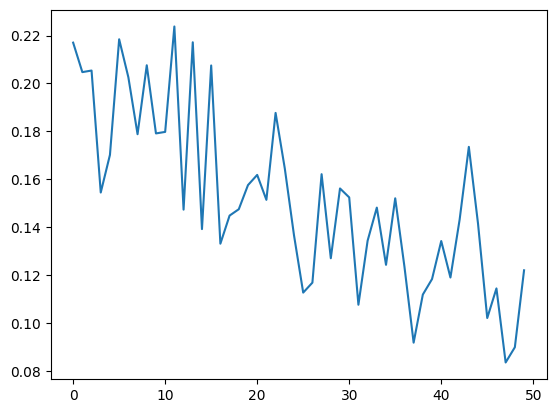

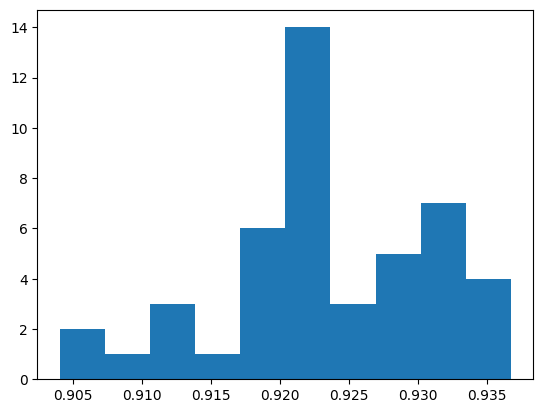

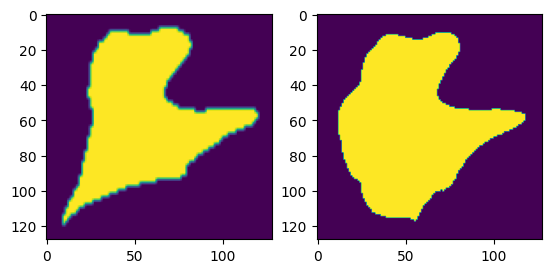

10001.png


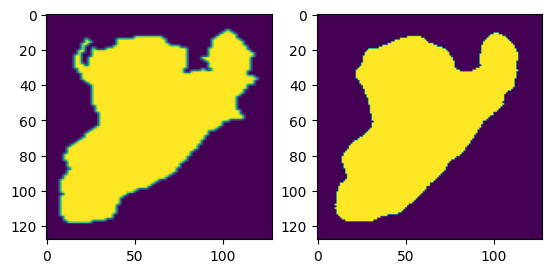

10002.png


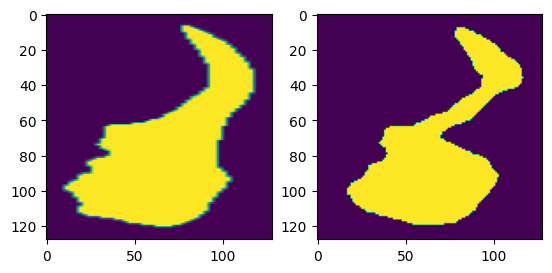

10003.png


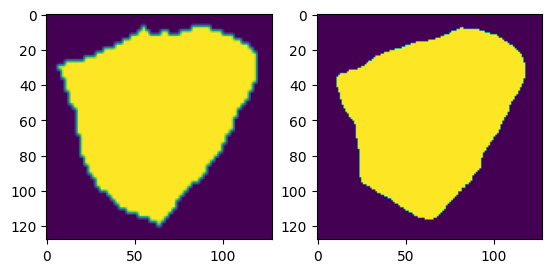

10004.png


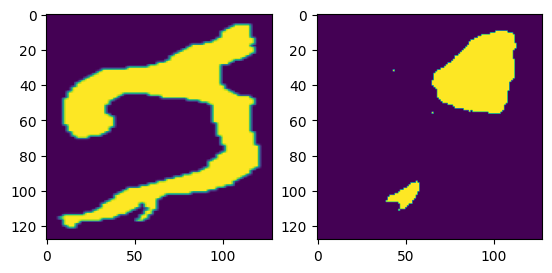

10005.png


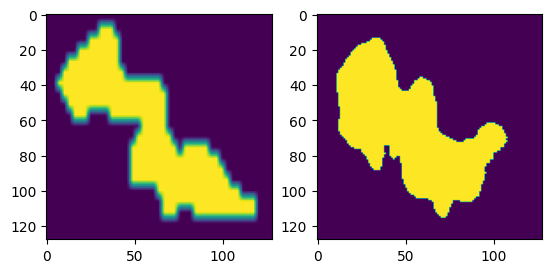

10006.png


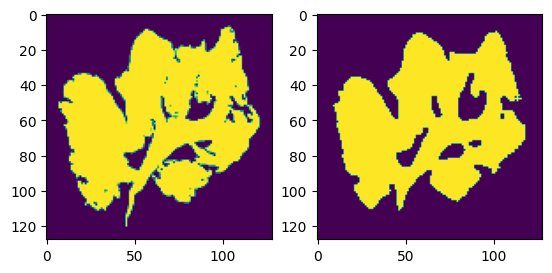

10007.png


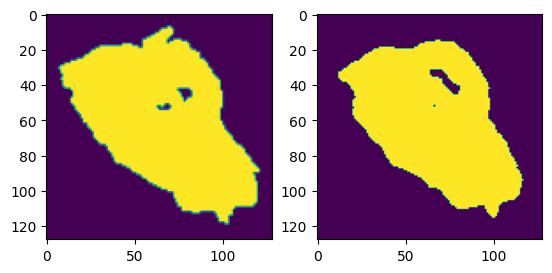

10008.png


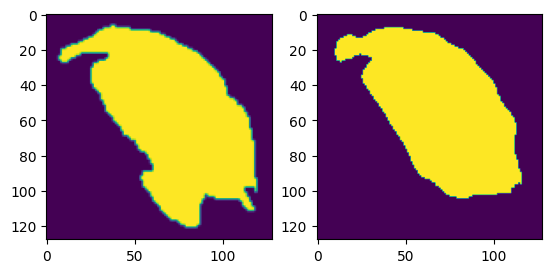

10009.png


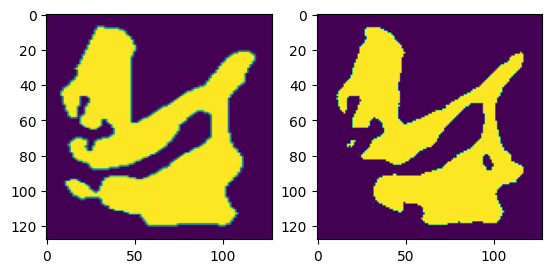

10010.png


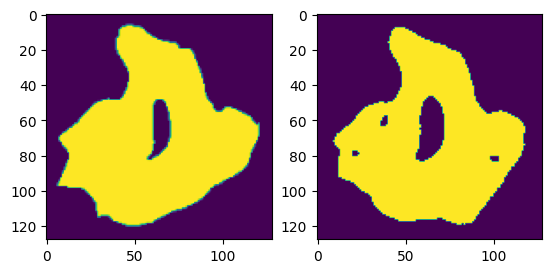

10011.png


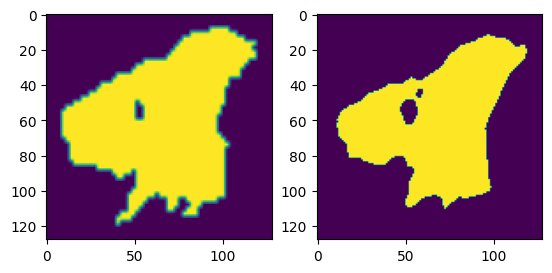

10012.png


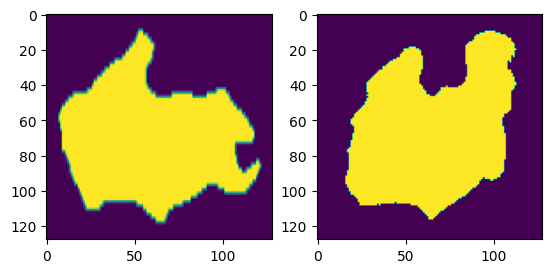

10013.png


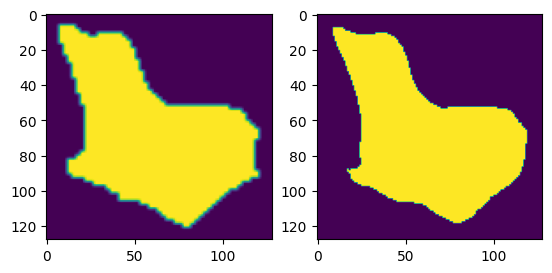

10014.png


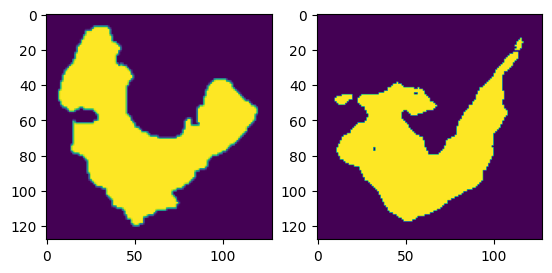

10015.png


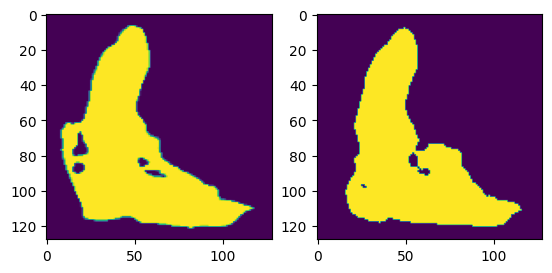

In [13]:
exp_folder = 'experiments/'

if not os.path.exists(exp_folder):
    os.mkdir(exp_folder)

if not os.path.exists(exp_folder+"thecounter.data"):
    counter = open(exp_folder+"thecounter.data","w")
    counter.write('10000')
    counter.close()
    
with open(exp_folder+"thecounter.data","r") as counter:
    count = int(counter.read())
    counter.close()

count += 1

if not os.path.exists(exp_folder+f"{count}"):
    os.makedirs(exp_folder+f"{count}")
    
new_folder = exp_folder + f"{count}/"

filename = new_folder+'hyperparameters.txt'

file = open(filename,'a+')
file.write(f"""Hyperparameters

LEARNING_RATE = {LEARNING_RATE}
WEIGHT_DECAY = {WEIGHT_DECAY}
UNFREEZE_WEIGHTS = {UNFREEZE_WEIGHTS}
EPOCHS = {EPOCHS}
EPOCH_FREEZE = {EPOCH_FREEZE}
PROB_THRESHOLD = {PROB_THRESHOLD}
MAKE_CSV = {MAKE_CSV}
TEST_SIZE = {TEST_SIZE}
TRANSFORMS = {TRANSFORMS}
LOSS = {LOSS}""")
file.close()

plt.figure(0)
plt.plot(train_losses)
plt.savefig(new_folder+'train_losses.png')

plt.figure(1)
plt.hist(dices)
plt.savefig(new_folder+'dice_hist.png')

torch.save(torch_model, new_folder+'model')

imgs, segs = next(iter(test_dataloader)) # 
outputs = torch_model.forward(imgs.to(device))
outputs = torch.softmax(outputs, dim=1)

if not os.path.exists(new_folder+'results/'):
    os.mkdir(new_folder+'results/')


plt.figure(2)
for IMG in range(16):
    plt.subplot(1,2,1)
    plt.imshow(segs[IMG,:,:,:].squeeze(0))
    plt.subplot(1,2,2)
    plt.imshow(outputs[IMG].detach().cpu().numpy()[1]>=PROB_THRESHOLD)
    print(f'{str(IMG+10000)}.png')
    plt.savefig(new_folder+f'results/{str(IMG+1000)}.png')
    plt.show()

counter = open(exp_folder+"thecounter.data","w")
counter.write(str(count))
counter.close()
